## Eye color classification

In [14]:
train_data_directory = 'dataset/train/eyes'
test_data_directory = 'dataset/test/eyes'

import cv2 # open cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

load_model = tf.keras.models.load_model
image = tf.keras.preprocessing.image
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Activation = tf.keras.layers.Activation
Flatten = tf.keras.layers.Flatten
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D

picture_width = 400
picture_height = 540

CLASSES = ['black','blue','brown']
MODEL_NAME = 'eyes'

In [16]:
# initiate data preprocessing tools

# This step processes the images into a format that
# 1. makes the data readable to the model
# 2. provides more training material for the model to train from
# the `training_data_processor` below scales the data so that it can be
# a model input, but also takes each image and augments it so that
# the model can learn from multiple variations of the same image.
# it flips it horizontally, rotates it, shifts it, and more so that 
# the model learns from the soil photo rather than the orientation size
training_data_processor  = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
)
# for the testing images, we don't need to create multiple variatinos
test_data_processor = ImageDataGenerator(rescale=1./255)


# load data into python

training_data = training_data_processor.flow_from_directory(
    train_data_directory,
    target_size = (picture_width, picture_height), # pixels
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (picture_width, picture_height),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 74 images belonging to 3 classes.
Found 29 images belonging to 3 classes.


### Model building

In [19]:
# choose model parameters
num_conv_layers = 3
num_dense_layers = 2
layer_size = 29 # limit the layer size as we dont want to over fit the model
num_training_epochs = 25

model = Sequential()

# begin adding properties to model variable
# e.g. add a convulutional layer
model.add(Conv2D(layer_size, (3,3), input_shape=(picture_width, picture_height, 3)))
model.add(Activation('relu')) # rectified linear unit
model.add(MaxPooling2D(pool_size=(2,2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# output layer
model.add(Dense(len(CLASSES)))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# use the data already loaded to train/tune the model
model.fit(
    training_data, 
    epochs = num_training_epochs, 
    validation_data = testing_data)

# save the trained model
model.save(f'h5_models/{MODEL_NAME}.h5')

Epoch 1/25
3/3 [==============================] - 10s 3s/step - loss: 2.1129 - accuracy: 0.3784 - val_loss: 1.3349 - val_accuracy: 0.3448
Epoch 2/25
3/3 [==============================] - 9s 2s/step - loss: 1.1441 - accuracy: 0.4324 - val_loss: 1.0910 - val_accuracy: 0.3103
Epoch 3/25
3/3 [==============================] - 11s 5s/step - loss: 1.1099 - accuracy: 0.2703 - val_loss: 1.0846 - val_accuracy: 0.3103
Epoch 4/25
3/3 [==============================] - 11s 5s/step - loss: 1.0969 - accuracy: 0.3378 - val_loss: 1.0678 - val_accuracy: 0.3793
Epoch 5/25
3/3 [==============================] - 11s 3s/step - loss: 1.0814 - accuracy: 0.4324 - val_loss: 1.0704 - val_accuracy: 0.4138
Epoch 6/25
3/3 [==============================] - 11s 3s/step - loss: 1.0690 - accuracy: 0.4189 - val_loss: 1.0520 - val_accuracy: 0.4483
Epoch 7/25
3/3 [==============================] - 12s 3s/step - loss: 1.0356 - accuracy: 0.5541 - val_loss: 0.9964 - val_accuracy: 0.6552
Epoch 8/25
3/3 [===================

In [18]:
model.evaluate(training_data)

3/3 [==============================] - 3s 897ms/step - loss: 0.6411 - accuracy: 0.7162


[0.6411091685295105, 0.7162162065505981]


     black: 0.00240
      blue: 0.14862
     brown: 0.84899

    Confidence: 84.90%
    Eye color: brown

    


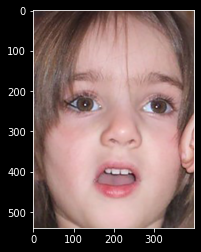

In [25]:
def classify(image_fp):
    im = cv2.imread(image_fp) # load the image from the given file path (image_fp)
    plt.imshow(im[:,:,[2,1,0]]) # swap the colors because open-cv swaps the rgb colors
    img = image.load_img(image_fp, target_size = (picture_width, picture_height))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)

    from tensorflow import keras
    model = keras.models.load_model(f'{MODEL_NAME}.h5')
    predicted_value = model.predict(img_batch)

    # accuracy = model.evaluate(training_data)
    
    out  = f"""
     black: {predicted_value[0][0]:.5f}
      blue: {predicted_value[0][1]:.5f}
     brown: {predicted_value[0][2]:.5f}

    Confidence: {(predicted_value[0][predicted_value.argmax()] * 100):.2f}%
    Eye color: {CLASSES[predicted_value.argmax()]}

    """
  # accuracy: {(accuracy[1]*100):.5f}
  #     loss: {(accuracy[0]*100):.5f}
    return out


test_prediction = classify('dataset/test/eyes/brown/100790261_7fc275f1bb.jpg')
print(test_prediction)